In [1]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path
sys.path.append('keyword_lists')  # Ensure the 'keyword_lists' folder is in the Python path

from arxiv_search import jsonl_folder_filtering
from keywords_auroc import auroc_search_terms
from keywords_auprc import auprc_search_terms

In [4]:
import os
os.getcwd()

'AUCIAYN/arxiv_search'

In [12]:
# Specify the path to the folder containing your JSONL files
input_folder_path = 'arxiv_data/'
output_folder_path = 'data'
metadata_keys = ['timestamp', 'yymm', 'arxiv_id', 'language', 'url']
# Call the jsonl_folder_filtering function
df_output = jsonl_folder_filtering(input_folder_path, auroc_search_terms, auprc_search_terms, 
                                   metadata_keys=metadata_keys,
                                   output_folder_path=output_folder_path,
                                   remove_latex=True,
                                   save_file=True,
                                   filename="arxiv_filter_auc.csv")

In [13]:
df_output

,text,text_id,timestamp,yymm,arxiv_id,language,url,contains_auroc,contains_auprc
0,{Introduction} The moduli space of flat conne...,0,2010-06-29T02:02:38,1006,1006.5340,en,https://arxiv.org/abs/1006.5340,False,True
1,{Introduction.}{secIntro} In this paper we p...,1,2011-06-07T02:01:40,1006,1006.5691,en,https://arxiv.org/abs/1006.5691,True,False
2,{Introduction} Nowadays the amount of informat...,2,2010-12-27T02:00:34,1006,1006.5278,en,https://arxiv.org/abs/1006.5278,True,False
3,{Introduction} In networks where edges appear ...,3,2010-06-29T02:02:49,1006,1006.5367,en,https://arxiv.org/abs/1006.5367,False,True
4,{Introduction} Good estimates of the correlati...,4,2010-07-01T02:01:28,1006,1006.5847,en,https://arxiv.org/abs/1006.5847,False,True
...,...,...,...,...,...,...,...,...,...
48855,{Introduction} Social networks are an abstrac...,48853,2020-11-04T02:18:07,2011,2011.01627,en,https://arxiv.org/abs/2011.01627,False,True
48856,{Introduction} {sect:intro} Directional wirel...,48854,2020-12-15T02:21:33,2011,2011.01683,en,https://arxiv.org/abs/2011.01683,False,True
48857,{Conclusions} In this work we introduced 3D-La...,48855,2020-11-05T02:18:14,2011,2011.01535,en,https://arxiv.org/abs/2011.01535,False,True
48858,"*{Acknowledgements} We thank Hou Pong Chan, J...",48856,2020-11-04T02:14:39,2011,2011.01565,en,https://arxiv.org/abs/2011.01565,False,True


## Visualizing number of citations over time

'figures/papers_over_time.png'

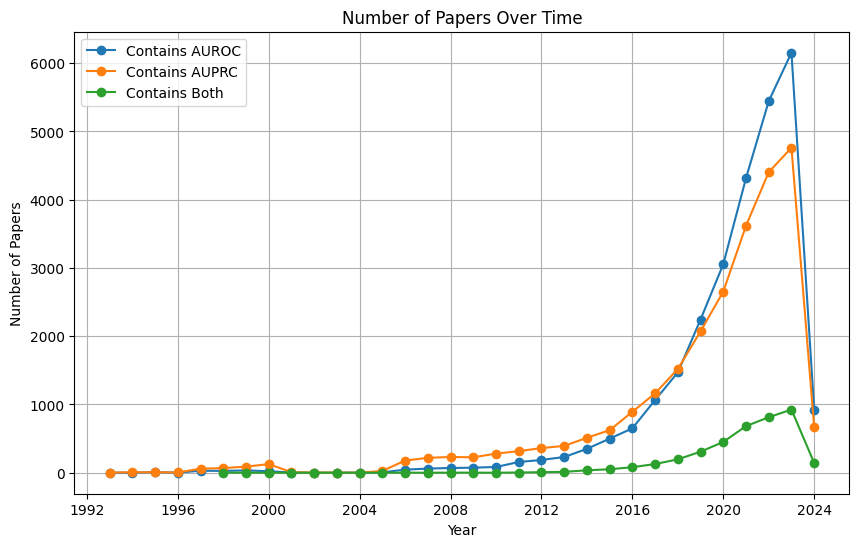

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert timestamp to datetime
df_output['timestamp'] = pd.to_datetime(df_output['timestamp'])

# Resample data by year
df_yearly = df_output.resample('Y', on='timestamp').agg({'contains_auroc': 'sum', 'contains_auprc': 'sum'})

# Calculate papers that contain both
df_yearly['contains_both'] = df_output[(df_output['contains_auroc'] == True) & (df_output['contains_auprc'] == True)].resample('Y', on='timestamp').size()

# File path for the figure
figures_dir = "figures"
figure_path = os.path.join(figures_dir, 'papers_over_time.png')

# Save the figure
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['contains_auroc'], label='Contains AUROC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_auprc'], label='Contains AUPRC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_both'], label='Contains Both', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers Over Time')
plt.legend()
plt.grid(True)
plt.savefig(figure_path)

figure_path

In [1]:
import pandas as pd
from tqdm import tqdm
import re

# Load data
df_output = pd.read_csv('data/arxiv_filter_auc.csv')

# Filter rows
df_filtered = df_output[(df_output['contains_auroc'] == True) & (df_output['contains_auprc'] == True)]


## Searching for specific claims that AUPRC is suprior to AUROC with GPT 3.5/4

In [3]:
window_size = 300  # Number of words

def create_keyword_pattern(keywords):
    """
    Create a regex pattern for keyword matching.
    """
    pattern = r'(?:(?<=\W)|(?<=^))(' + '|'.join(map(re.escape, keywords)) + r')(?=\W|$)'
    return re.compile(pattern, re.IGNORECASE)

def get_context_windows(text, keywords, window_size):
    """
    Extract context windows around keywords in the text, ensuring that overlapping
    windows are merged into one.
    """
    context_windows = []
    keyword_pattern = create_keyword_pattern(keywords)

    matches = list(keyword_pattern.finditer(text))
    merged_matches = []

    i = 0
    while i < len(matches):
        current_match = matches[i]
        start_pos = current_match.start()
        end_pos = current_match.end()

        # Check if the next matches are within the window size
        while i + 1 < len(matches) and matches[i + 1].start() - end_pos <= window_size * 2:
            i += 1
            end_pos = matches[i].end()

        merged_matches.append((start_pos, end_pos))
        i += 1

    for start_pos, end_pos in merged_matches:
        words = text.split()
        start_word_pos = len(text[:start_pos].split()) - 1
        end_word_pos = len(text[:end_pos].split())
        context_words = words[max(0, start_word_pos - window_size):min(len(words), end_word_pos + window_size)]
        context_str = ' '.join(context_words)
        context_windows.append(context_str)

    return context_windows

### Importing function to extract context window

In [ ]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path
from claim_search_openai import get_context_windows

## Extracting context windows in my data

In [12]:
# Use the updated get_context_windows function
new_data = []
for idx, row in df_filtered.iterrows():
    context_windows = get_context_windows(row['text'], auroc_search_terms, window_size)
    for context_window in context_windows:
        new_row = row.to_dict()
        new_row['context_window'] = context_window
        new_data.append(new_row)

# Create a new DataFrame with the context windows
new_df = pd.DataFrame(new_data)

### Defining prompt and importing function

In [26]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path
from claim_search_openai import process_with_gpt

In [14]:
# Define the system prompt
SYSTEM_PROMPT = (
    "You are an expert in machine learning and scientific literature review. "
    "For each chunk of a published paper (which may have typos, misspellings, and odd characters as a result of conversion from PDF), "
    "return a string that states whether or not the paper makes any claim that the area under the receiver operating characteristic (AUROC) "
    "is superior as a general performance metric compared to the area under the precision recall curve (AUPRC) in a machine learning setting. "
    "A paper claiming that AUROC should be preferred over AUPRC, especially in contexts such as imbalanced datasets, is an example of this metric commentary. "
    "Respond with format 'DESCRIPTION OF CLAIM GOES HERE' "
    "If the paper makes no claims favoring AUROC over AUPRC, please respond with 'NONE'."
)

In [ ]:
openai_api_key = "INSERT KEY HERE"

# Process each context window with GPT
for idx, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-3.5-turbo-1106", SYSTEM_PROMPT, openai_api_key)
    new_df.at[idx, 'gpt_response'] = gpt_response

# Optionally, you can save the DataFrame with GPT responses
new_df.to_csv('data/processed_gpt_responses.csv', index=False)

In [19]:
#new_df.to_csv('data/processed_gpt_responses.csv', index=False)
print(new_df['gpt_response'][5])

NONE


In [20]:
gpt_filter_3_5 = new_df[new_df['gpt_response'] != 'NONE']


In [21]:
print(gpt_filter_3_5)

                                                    text  text_id  \
0      {Introduction}  Graph neural networks (GNNs) h...       24   
3      {Introduction}  Graph neural networks (GNNs) h...       24   
4      {Introduction}  Graph neural networks (GNNs) h...       24   
6      *{Background} Embedded feature selection in hi...       27   
8      {Introduction}  Relatedness {hidalgo2018princi...       29   
...                                                  ...      ...   
18246  {Introduction} {sec:Intro} Even though the ori...    48836   
18247  {Introduction} {sec:Intro} Even though the ori...    48836   
18248  *{Introduction}  The collective behaviour of a...    48838   
18250  *{Introduction}  The collective behaviour of a...    48838   
18251  *{Introduction}  The collective behaviour of a...    48838   

                 timestamp  yymm    arxiv_id language  \
0      2022-06-08T02:01:12  2202  2202.00529       en   
3      2022-06-08T02:01:12  2202  2202.00529       en   


In [22]:
# Assuming filtered_df is your DataFrame after filtering
unique_document_count = gpt_filter_3_5['text_id'].nunique()

# Print the count of unique documents
print(f"Found {unique_document_count} documents that GPT 3.5 thinks are relevant.")

Found 2728 documents that GPT 3.5 thinks are relevant.


## Doing it with gpt 4.0 Turbo

### Defining prompt (made adjustments since the old prompt did not seem sufficient)

In [13]:
SYSTEM_PROMPT = (
    "You are an expert in machine learning and scientific literature review. "
    "For each chunk of a published paper (which may have typos, misspellings, and odd characters as a result of conversion from PDF), "
    "examine whether the paper makes any claim that the area under the receiver operating characteristic (AUROC) "
    "is superior as a general performance metric compared to the area under the precision recall curve (AUPRC) in a machine learning setting. "
    "If the paper makes a specific claim favoring AUROC over AUPRC, especially in contexts such as imbalanced datasets, "
    "respond with the format: Paper claim: 'INPUT PAPER CLAIM HERE'. "
    "If the paper makes no such claims, respond with 'NONE'."
)


In [ ]:
# Process each context window with GPT
for idx, row in tqdm(gpt_filter_3_5.iterrows(), total=gpt_filter_3_5.shape[0]):
    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key)
    gpt_filter_3_5.at[idx, 'gpt_response_4_0'] = gpt_response

# Optionally, you can save the DataFrame with GPT responses
gpt_filter_3_5.to_csv('data/processed_gpt_responses_gpt4.csv', index=False)

### Saving only rows where GPT found claims

In [32]:
filtered_df_gpt_4_0_v1 = gpt_filter_3_5[gpt_filter_3_5['gpt_response_4_0'].notna() & (gpt_filter_3_5['gpt_response_4_0'] != 'NONE') & (gpt_filter_3_5['gpt_response_4_0'] != 'Error: Rate limit retries exceeded')]


In [33]:
print(filtered_df_gpt_4_0_v1)

                                                    text  text_id  \
8      {Introduction}  Relatedness {hidalgo2018princi...       29   
15     {Introduction} Transcriptomics is a powerful t...       63   
44     *{Appendix for Disease-Atlas} {Tests on Cystic...      121   
45     *{Appendix for Disease-Atlas} {Tests on Cystic...      121   
74     {Introduction} Surveillance cameras can sense ...      220   
...                                                  ...      ...   
10203  {Introduction}  Anomaly detection has been wid...    26574   
10204  {Introduction}  Anomaly detection has been wid...    26574   
10235  {Introduction}  Drug-drug interactions (DDIs) ...    26641   
10361  {Introduction} {sec:introduction}  Electronic ...    27119   
10362  {Introduction} {sec:introduction}  Electronic ...    27119   

                 timestamp  yymm    arxiv_id language  \
8      2022-06-22T02:44:46  2202  2202.00458       en   
15     2021-02-02T02:23:16  2102  2102.00538       en   


In [34]:
filtered_df_gpt_4_0_v1.to_csv('data/filtered_df_gpt_4_0_v1.csv', index=False)

## Since I reached Rate limit I am trying with the rest

### So we start by filtering the reponses that are NaN or where the Rate limit is exceed

In [36]:
filtered_df_gpt_4_0_v2 = gpt_filter_3_5[
    gpt_filter_3_5['gpt_response_4_0'].isna() | 
    (gpt_filter_3_5['gpt_response_4_0'] == "Error: Rate limit retries exceeded")
]


In [ ]:
# Process each context window with GPT
for idx, row in tqdm(filtered_df_gpt_4_0_v2.iterrows(), total=filtered_df_gpt_4_0_v2.shape[0]):
    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key)
    filtered_df_gpt_4_0_v2.at[idx, 'gpt_response_4_0'] = gpt_response

## Since I reached Rate limit, I am trying with the rest

### First I will save the ones I have (that are deemed relevant)

In [40]:
filtered_df_gpt_4_0_v3 = filtered_df_gpt_4_0_v2[filtered_df_gpt_4_0_v2['gpt_response_4_0'].notna() & (filtered_df_gpt_4_0_v2['gpt_response_4_0'] != 'NONE') & (filtered_df_gpt_4_0_v2['gpt_response_4_0'] != 'Error: Rate limit retries exceeded')]

In [41]:
filtered_df_gpt_4_0_v3.to_csv('data/processed_gpt_responses_gpt4_v3.csv', index=False)

### Now searching for the rest

In [47]:
filtered_df_gpt_4_0_v4 = filtered_df_gpt_4_0_v2[
    filtered_df_gpt_4_0_v2['gpt_response_4_0'].isna() | 
    (filtered_df_gpt_4_0_v2['gpt_response_4_0'] == "Error: Rate limit retries exceeded")
]


In [ ]:
# Process each context window with GPT
for idx, row in tqdm(filtered_df_gpt_4_0_v4.iterrows(), total=filtered_df_gpt_4_0_v4.shape[0]):
    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key)
    filtered_df_gpt_4_0_v4.at[idx, 'gpt_response_4_0'] = gpt_response


## Since I reached Rate limit, I am trying with the rest

### First I will save the ones I have

In [49]:
filtered_df_gpt_4_0_v5 = filtered_df_gpt_4_0_v4[filtered_df_gpt_4_0_v4['gpt_response_4_0'].notna() & (filtered_df_gpt_4_0_v4['gpt_response_4_0'] != 'NONE') & (filtered_df_gpt_4_0_v4['gpt_response_4_0'] != 'Error: Rate limit retries exceeded')]


In [51]:
filtered_df_gpt_4_0_v5.to_csv('data/processed_gpt_responses_gpt4_v5.csv', index=False)

### I will save the last dataframe, that needs to be searched here

In [52]:
filtered_df_gpt_4_0_v6 = filtered_df_gpt_4_0_v4[
    filtered_df_gpt_4_0_v4['gpt_response_4_0'].isna() | 
    (filtered_df_gpt_4_0_v4['gpt_response_4_0'] == "Error: Rate limit retries exceeded")
]


In [58]:
filtered_df_gpt_4_0_v6.to_csv('data/processed_gpt3_responses_rest.csv', index=False)

### Loading the df again since I restarted the kernel

In [5]:
import pandas as pd
filtered_df_gpt_4_0_v6 = pd.read_csv('data/processed_gpt3_responses_rest.csv')

In [ ]:
# Introduce a delay between API calls
api_call_delay = 1.0  # Adjust this delay as needed

from tqdm import tqdm 

for idx, row in tqdm(filtered_df_gpt_4_0_v6.iterrows(), total=filtered_df_gpt_4_0_v6.shape[0]):
    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key, api_call_delay)
    filtered_df_gpt_4_0_v6.at[idx, 'gpt_response_4_0'] = gpt_response
    time.sleep(api_call_delay)  # Throttle the API calls


## Hit a throttle, continuing from line 794

In [ ]:
# Introduce a delay between API calls
api_call_delay = 4  # Adjust this delay as needed

from tqdm import tqdm
import time

resume_idx = 794  # Set this to the index where you want to resume processing

for idx, row in tqdm(filtered_df_gpt_4_0_v6.iterrows(), total=filtered_df_gpt_4_0_v6.shape[0]):
    if idx < resume_idx:
        continue  # Skip to the next iteration until we reach the resume index

    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key, api_call_delay)
    filtered_df_gpt_4_0_v6.at[idx, 'gpt_response_4_0'] = gpt_response
    time.sleep(api_call_delay)  # Throttle the API calls


## Hit a throttle, continuing from line 1061

In [ ]:
# Introduce a delay between API calls
api_call_delay = 5  # Adjust this delay as needed

from tqdm import tqdm
import time

resume_idx = 1061  # Set this to the index where you want to resume processing

for idx, row in tqdm(filtered_df_gpt_4_0_v6.iterrows(), total=filtered_df_gpt_4_0_v6.shape[0]):
    if idx < resume_idx:
        continue  # Skip to the next iteration until we reach the resume index

    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key, api_call_delay)
    filtered_df_gpt_4_0_v6.at[idx, 'gpt_response_4_0'] = gpt_response
    time.sleep(api_call_delay)  # Throttle the API calls


### Stopped at 1391

In [ ]:
# Introduce a delay between API calls
api_call_delay = 5  # Adjust this delay as needed

from tqdm import tqdm
import time

resume_idx = 1391  # Set this to the index where you want to resume processing

for idx, row in tqdm(filtered_df_gpt_4_0_v6.iterrows(), total=filtered_df_gpt_4_0_v6.shape[0]):
    if idx < resume_idx:
        continue  # Skip to the next iteration until we reach the resume index

    context_window = row['context_window']
    gpt_response = process_with_gpt(context_window, "gpt-4-1106-preview", SYSTEM_PROMPT, openai_api_key, api_call_delay)
    filtered_df_gpt_4_0_v6.at[idx, 'gpt_response_4_0'] = gpt_response
    time.sleep(api_call_delay)  # Throttle the API calls


## Got 73% but we hit limit of API key, stopping for now

In [21]:
filtered_df_gpt_4_0_v7 = filtered_df_gpt_4_0_v6[filtered_df_gpt_4_0_v6['gpt_response_4_0'].notna() & (filtered_df_gpt_4_0_v6['gpt_response_4_0'] != 'NONE') & (filtered_df_gpt_4_0_v6['gpt_response_4_0'] != 'Error: Rate limit retries exceeded')]

filtered_df_gpt_4_0_v7.to_csv('data/processed_gpt_responses_gpt4_v7.csv', index=False)

### Saving the last papers I have not gone through yet

In [25]:
filtered_df_gpt_4_0_v8 = filtered_df_gpt_4_0_v6[
    filtered_df_gpt_4_0_v6['gpt_response_4_0'].isna() | 
    (filtered_df_gpt_4_0_v6['gpt_response_4_0'] == "Error: Rate limit retries exceeded")
]

filtered_df_gpt_4_0_v8.to_csv('data/last_papers_not_gone_through_arxiv_search.csv', index=False)